<a href="https://colab.research.google.com/github/AdiY2j/CS6910_Assignment1/blob/main/Assignment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 18.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.4/195.4 kB 17.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 263.5/263.5 kB 19.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 6.5 MB/s eta 0:00:00


In [4]:
import wandb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
np.set_printoptions(suppress=True)
from keras.datasets import fashion_mnist

In [5]:
wandb.login(key='72a114321dd97dbf11db7b15eb05b2660c2faa94')

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

Q1] Download the fashion-MNIST dataset and plot 1 sample image for each class

In [6]:
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

4422102/4422102 [==============================] - 0s 0us/step


In [7]:
X_train.shape[0]

60000

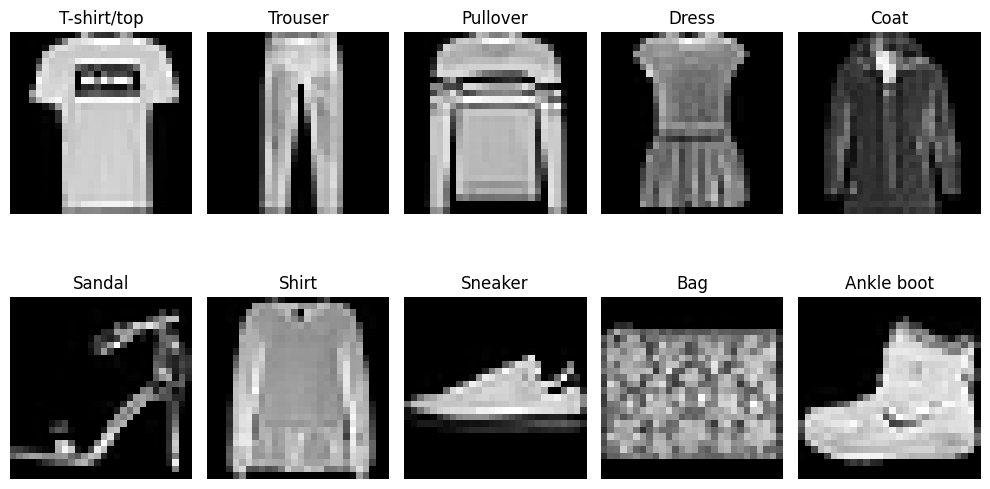

In [8]:
#wandb.init(project = 'DL_Assignment_1', entity = 'cs23m009')
class_labels = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

images = []
labels = []
# Function to plot one sample image for each class
def plot_data(x, y, class_labels):
    plt.figure(figsize=(10, 6))

    for i in range(len(class_labels)):
        id = np.where(y == i)[0][0]
        image = x[id]
        plt.subplot(2, 5, i+1)
        plt.axis('off')
        plt.imshow(image, cmap='gray')
        plt.title(class_labels[i])
        images.append(image)
        labels.append(class_labels[i])

    plt.tight_layout()
    plt.show()

plot_data(X_train, y_train, class_labels)
# wandb.log({"Question 1 " : [wandb.Image(image , caption = f"Label: {label}") for image, label in zip(images, labels)]})
# wandb.finish()

In [9]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

In [10]:
X_train = np.array(X_train)
X_val = np.array(X_val)
X_test = np.array(X_test)
# Reshape input feature from 28*28 to 784*1
X_train = X_train.reshape(X_train.shape[0], -1) / 255.0
X_val = X_val.reshape(X_val.shape[0], -1) / 255.0
X_test = X_test.reshape(X_test.shape[0], -1) / 255.0

In [11]:
X_train.shape

(54000, 784)

In [12]:
X_val.shape

(6000, 784)

In [13]:
def initializeParam(layers, activation, weight_init = "random"):
  params = {}
  for i in range(1, len(layers)):
    if weight_init == "Xavier" or activation == "relu":
      params['W' + str(i)] = np.random.randn(layers[i], layers[i-1]) * np.sqrt(2/float(layers[i-1]))
    elif weight_init == "random":
      params['W' + str(i)] = np.random.randn(layers[i], layers[i-1])

    params['b' + str(i)] = np.zeros((layers[i], 1))
  return params

In [14]:
def sigmoid(x):
  return 1 / (1 + np.exp(-x))

def relu(x):
  return np.maximum(0, x)

def tanh(x):
  return np.tanh(x)

def sigmoid_dev(x):
  return x * (1 - x)

def relu_dev(x):
  return np.where(x > 0, 1, 0)

def tanh_dev(x):
  return 1 - x**2

def softmax(x):
  x = np.clip(x, -700, 700)
  return np.exp(x) / np.sum(np.exp(x), axis = 0)

Q2] Implement a feedforward neural network which takes images from the fashion-mnist data as input and outputs a probability distribution over the 10 classes.

In [15]:
def forward_prop(X, layers, params, activation):
  func = {}
  func['h0'] = X
  func['a0'] = X
  output = []
  for i in range(1, len(layers)):
    a = np.dot(params['W' + str(i)], func['h' + str(i-1)].T) + params['b' + str(i)]

    #print(params['W' + str(i)].shape, func['h' + str(i-1)].T.shape, params['b' + str(i)].shape, a.shape)

    if(i == len(layers) - 1) :
      h = softmax(a)
      output = h
    else :
      if activation == "sigmoid" :
        h = sigmoid(a)
      elif activation == "relu" :
        h = relu(a)
      elif activation == "tanh" :
        h = tanh(a)

    func['a' + str(i)] = a.T
    func['h' + str(i)] = h.T

  return output, func

Q3] Implement the backpropagation algorithm with support for the following optimisation functions

In [16]:
def back_prop(func, params, y, pred_y, L, loss_func, activation):
  m = y.size
  gradients = {}
  if loss_func == "cross_entropy" :
    dL_a = pred_y - y.T
  elif loss_func == "squared_loss" :
    dL_a = 2*(pred_y - y.T) * pred_y

  h_prev = func['h'+str(L)]
  act_dev = sigmoid_dev

  if activation == "sigmoid":
    act_dev = sigmoid_dev
  elif activation == "relu":
    act_dev = relu_dev
  elif activation == "tanh":
    act_dev = tanh_dev

  for k in range(L, -1, -1):
    dL_W = np.dot(dL_a, h_prev)
    dL_b = np.sum(dL_a, axis=1, keepdims=True)

    #print(dL_W.shape, dL_b.shape)

    dL_h = np.dot(params['W'+str(k+1)].T,  dL_a)
    dL_a = dL_h * act_dev(h_prev).T  #sigmoid (h_prev * (1- h_prev)).T

    gradients['dW' + str(k+1)] = dL_W
    gradients['db' + str(k+1)] = dL_b
    if(k-1 > -1):
      h_prev = func['h' + str(k-1)]


  return gradients

In [17]:
def sgd(params, gradients, eta, L, decay):
  for i in range(1, L):
    params['W' + str(i)] -=  eta * (gradients['dW' + str(i)] + decay * params['W' + str(i)])
    params['b' + str(i)] -=  eta * (gradients['db' + str(i)] + decay * params['b' + str(i)])

In [18]:
def mgd(params, gradients, history, max_epochs, momentum, eta, L, decay):
  for key in params.keys():
    if key not in history:
      history[key] = np.zeros_like(params[key])
    history[key] = momentum * history[key] + eta * (gradients['d' + key] + decay * params[key])
    params[key] -= history[key]


In [19]:
def nag(params, gradients, history, max_epochs, momentum, eta, L, decay):
  for i in range(1, L):
    history['W' + str(i)] = momentum * history['W' + str(i)] + eta * (gradients['dW' + str(i)] + decay * params['W' + str(i)])
    history['b' + str(i)] = momentum * history['b' + str(i)] + eta * (gradients['db' + str(i)] + decay * params['b' + str(i)])

    params['W' + str(i)] -= history['W' + str(i)]
    params['b' + str(i)] -= history['b' + str(i)]

In [20]:
def rmsprop(params, gradients, history, max_epochs, beta, eta, eps, L, decay):
  for key in params.keys():
    if key not in history:
      history[key] = np.zeros_like(params[key])

  for i in range(1, L):
    history['W' + str(i)] = beta * history['W' + str(i)] + (1 - beta) * gradients['dW' + str(i)]**2
    history['b' + str(i)] = beta * history['b' + str(i)] + (1 - beta) * gradients['db' + str(i)]**2

    params['W' + str(i)] -= (eta * gradients['dW' + str(i)]/(np.sqrt(history['W' + str(i)]) + eps)) + (eta * decay * params['W' + str(i)])
    params['b' + str(i)] -= (eta * gradients['db' + str(i)]/(np.sqrt(history['b' + str(i)]) + eps)) + (eta * decay * params['b' + str(i)])

In [21]:
def adam(params, gradients, history, moment, max_epochs, beta1, beta2, eta, eps, L, t, decay):
  for key in params.keys():
    if key not in history:
      history[key] = np.zeros_like(params[key])
    if key not in moment:
      moment[key] = np.zeros_like(params[key])

  for i in range(1, L):
    moment['W'+str(i)] = beta1 * moment['W'+str(i)] + (1-beta1) * gradients['dW'+str(i)]
    moment['b'+str(i)] = beta1 * moment['b'+str(i)] + (1-beta1) * gradients['db'+str(i)]
    history['W'+str(i)] = beta2 * history['W'+str(i)] + (1-beta2) * gradients['dW'+str(i)]**2
    history['b'+str(i)] = beta2 * history['b'+str(i)] + (1-beta2) * gradients['db'+str(i)]**2

    m_w_hat = moment['W'+str(i)]/(1 - (beta1 ** t))
    m_b_hat = moment['b'+str(i)]/(1 - (beta1 ** t))
    v_w_hat = history['W'+str(i)]/(1 - (beta2 ** t))
    v_b_hat = history['b'+str(i)]/(1 - (beta2 ** t))

    params['W'+str(i)] -= eta * m_w_hat/(np.sqrt(v_w_hat) + eps) + (eta * decay * params['W' + str(i)])
    params['b'+str(i)] -= eta * m_b_hat/(np.sqrt(v_b_hat) + eps) + (eta * decay * params['b' + str(i)])


In [22]:
def nadam(params, gradients, history, moment, max_epochs, beta1, beta2, eta, eps, L, t, decay):
  for key in params.keys():
    if key not in history:
      history[key] = np.zeros_like(params[key])
    if key not in moment:
      moment[key] = np.zeros_like(params[key])

  for i in range(1, L):
    moment['W'+str(i)] = beta1 * moment['W'+str(i)] + (1-beta1) * gradients['dW'+str(i)]
    moment['b'+str(i)] = beta1 * moment['b'+str(i)] + (1-beta1) * gradients['db'+str(i)]
    history['W'+str(i)] = beta2 * history['W'+str(i)] + (1-beta2) * gradients['dW'+str(i)]**2
    history['b'+str(i)] = beta2 * history['b'+str(i)] + (1-beta2) * gradients['db'+str(i)]**2

    m_w_hat = moment['W'+str(i)]/(1 - (beta1 ** t))
    m_b_hat = moment['b'+str(i)]/(1 - (beta1 ** t))
    v_w_hat = history['W'+str(i)]/(1 - (beta2 ** t))
    v_b_hat = history['b'+str(i)]/(1 - (beta2 ** t))

    params['W'+str(i)] -= (eta/np.sqrt(v_w_hat + eps)) * (beta1 * m_w_hat + (1-beta1) * gradients['dW'+str(i)] / (1 - beta1**t)) + (eta * decay * params['W' + str(i)])
    params['b'+str(i)] -= (eta/np.sqrt(v_b_hat + eps)) * (beta1 * m_b_hat + (1-beta1) * gradients['db'+str(i)] / (1 - beta1**t)) + (eta * decay * params['b' + str(i)])

In [23]:
def compute_loss(y, y_pred, loss, epsilon=1e-10):
  if loss == "squared_loss":
    return np.sum((y - y_pred)**2)/y.shape[0]
  elif loss == "cross_entropy":
    return -np.sum(np.multiply(y, np.log(y_pred + epsilon)))/y.shape[0]

In [24]:
def loss_dev(y, y_pred, loss):
  if loss == "cross_entropy":
    return -y/y_pred
  elif loss == "squared_loss":
    return y_pred - y

In [25]:
def get_prediction(output):
  return np.argmax(output, axis=0)

def get_accuracy(prediction, Y):
  #print(prediction, Y)
  return np.sum(prediction == Y)/Y.size

def cal_confusion(prediction, Y):
  count = 0
  confusion_mat = np.zeros((10, 10))
  for i in range(len(prediction)):
    confusion_mat[prediction[i]][Y[i]] += 1
  print(confusion_mat)

In [26]:
def lookahead(params, history, momentum):
  for key in params.keys():
    if key not in history:
      history[key] = np.zeros_like(params[key])
    else :
      history[key] = momentum * history[key]
    params[key] -= history[key]

In [32]:
sweep_config = {
    'method' : 'bayes',
    'metric' : {
        'name' : 'val_accuracy',
        'goal' : 'maximize'
    },
    'parameters' : {
        'epochs' : {
            'values' : [5, 10]
        },
        'batch_size' : {
            'values' : [16, 32, 64]
        },
        'learning_rate': {
            'values' : [1e-3, 5e-3, 1e-4]
        },
        'hidden_layers' : {
            'values' : [3, 4, 5]
        },
        'hidden_layer_size' :  {
            'values' : [32, 64, 128]
        },
        'weight_init' : {
            'values' : ['random', 'Xavier']
        },
        'weight_decay' : {
            'values' : [0, 0.005]
        },
        'optimizer' : {
            'values' : ['adam', 'nadam']
        },
        'activation' : {
            'values' : ['sigmoid', 'relu', 'tanh']
        }
    }
}

In [33]:
sweep_id = wandb.sweep(sweep=sweep_config, project='DL_Assignment_1', entity = "cs23m009")

Create sweep with ID: mj4hwme9
Sweep URL: https://wandb.ai/cs23m009/DL_Assignment_1/sweeps/mj4hwme9


In [34]:
def main():
  with wandb.init() as run:
    run_name = 'o_{}_a_{}_lr_{}_hl{}_bs{}_w_{}'.format(wandb.config.optimizer, wandb.config.activation, wandb.config.learning_rate, str(wandb.config.hidden_layer_size) + "_" + str(wandb.config.hidden_layers), wandb.config.batch_size, wandb.config.weight_init)
    wandb.run.name = run_name
    train(X_train, y_train, wandb.config["hidden_layer_size"], wandb.config["hidden_layers"], "cross_entropy", wandb.config["activation"], wandb.config["weight_init"], wandb.config["learning_rate"], wandb.config["epochs"], wandb.config["batch_size"], wandb.config["optimizer"], wandb.config["weight_decay"])

wandb.agent(sweep_id, function = main, count = 10)
wandb.finish()

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.
wandb: Agent Starting Run: u8l94acp with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 32
wandb: 	hidden_layers: 3
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: Xavier
Exception in thread ChkStopThr:
Traceback (most recent call last):
  File "/usr/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
Exception in thread NetStatThr:
Traceback (most recent call last):
  File "/usr/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
Exception in thread IntMsgThr:
Traceback (most recent call last):
  File "/usr/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.10/threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/wandb/sdk/wandb_run.py", line 300, in check_internal_messages
 

Epoch 1, Train Loss: 0.41966541090562876, Train Accuracy: 0.8510925925925926, Val Loss: 0.43783959005344536, Val Accuracy: 0.8438333333333333
Epoch 2, Train Loss: 0.3808444279160935, Train Accuracy: 0.8613148148148149, Val Loss: 0.40859397510834505, Val Accuracy: 0.8518333333333333
Epoch 3, Train Loss: 0.36315546786059316, Train Accuracy: 0.8663518518518518, Val Loss: 0.3968786287884515, Val Accuracy: 0.8563333333333333
Epoch 4, Train Loss: 0.34983613384677986, Train Accuracy: 0.8713703703703704, Val Loss: 0.38885267692341746, Val Accuracy: 0.8613333333333333
Epoch 5, Train Loss: 0.34001913749588714, Train Accuracy: 0.8750185185185185, Val Loss: 0.3834174754308819, Val Accuracy: 0.8645


epoch,▁▃▅▆█
train_accuracy,▁▄▅▇█
train_loss,█▅▃▂▁
val_accuracy,▁▄▅▇█
val_loss,█▄▃▂▁
epoch,5
train_accuracy,0.87502
train_loss,0.34002
val_accuracy,0.8645
val_loss,0.38342


wandb: Agent Starting Run: n262yeej with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	hidden_layers: 5
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.005
wandb: 	weight_init: random


Epoch 1, Train Loss: 0.491285832524638, Train Accuracy: 0.8239444444444445, Val Loss: 0.4953203155899408, Val Accuracy: 0.821
Epoch 2, Train Loss: 0.44163164593781196, Train Accuracy: 0.8405555555555555, Val Loss: 0.457245375073485, Val Accuracy: 0.835
Epoch 3, Train Loss: 0.41650181261137464, Train Accuracy: 0.8495555555555555, Val Loss: 0.43949894018040936, Val Accuracy: 0.8416666666666667
Epoch 4, Train Loss: 0.3982168446265634, Train Accuracy: 0.856925925925926, Val Loss: 0.42569770739983775, Val Accuracy: 0.8496666666666667
Epoch 5, Train Loss: 0.3837410508942416, Train Accuracy: 0.8623703703703703, Val Loss: 0.4160324369579362, Val Accuracy: 0.8518333333333333
Epoch 6, Train Loss: 0.3708978182950544, Train Accuracy: 0.8667222222222222, Val Loss: 0.40832141611250844, Val Accuracy: 0.8553333333333333
Epoch 7, Train Loss: 0.35937262142153525, Train Accuracy: 0.8708703703703704, Val Loss: 0.4018822214136143, Val Accuracy: 0.8566666666666667
Epoch 8, Train Loss: 0.3490573167315865, Tr

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▄▅▆▆▇▇██
train_loss,█▆▅▄▃▃▂▂▁▁
val_accuracy,▁▃▄▆▆▇▇███
val_loss,█▆▄▄▃▂▂▂▁▁
epoch,10
train_accuracy,0.88011
train_loss,0.33162
val_accuracy,0.86333
val_loss,0.38625


wandb: Agent Starting Run: 6pk6l9oz with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 4
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: Xavier


Epoch 1, Train Loss: 0.4134571634386186, Train Accuracy: 0.8556851851851852, Val Loss: 0.4246124789975051, Val Accuracy: 0.8453333333333334
Epoch 2, Train Loss: 0.3534231412135504, Train Accuracy: 0.8741296296296296, Val Loss: 0.37441328072116214, Val Accuracy: 0.8633333333333333
Epoch 3, Train Loss: 0.32849727489239794, Train Accuracy: 0.8820370370370371, Val Loss: 0.35707658430974465, Val Accuracy: 0.8698333333333333
Epoch 4, Train Loss: 0.3065961496720642, Train Accuracy: 0.8896296296296297, Val Loss: 0.34668889015205084, Val Accuracy: 0.8771666666666667
Epoch 5, Train Loss: 0.2928187570366071, Train Accuracy: 0.8948518518518519, Val Loss: 0.3448198443836521, Val Accuracy: 0.878
Epoch 6, Train Loss: 0.2802848894867871, Train Accuracy: 0.8997222222222222, Val Loss: 0.3426748952268679, Val Accuracy: 0.8801666666666667
Epoch 7, Train Loss: 0.26818506403922776, Train Accuracy: 0.9032407407407408, Val Loss: 0.3399528425170356, Val Accuracy: 0.8818333333333334
Epoch 8, Train Loss: 0.26003

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▄▅▆▇▇▇██
train_loss,█▆▅▄▃▃▂▂▁▁
val_accuracy,▁▄▅▇▇▇████
val_loss,█▄▂▂▁▁▁▁▁▁
epoch,10
train_accuracy,0.91054
train_loss,0.24326
val_accuracy,0.88367
val_loss,0.34262


wandb: Agent Starting Run: ycqfphuw with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 5
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: Xavier


Epoch 1, Train Loss: 0.4802668237688887, Train Accuracy: 0.831037037037037, Val Loss: 0.4909621943472629, Val Accuracy: 0.8245
Epoch 2, Train Loss: 0.3946404230081081, Train Accuracy: 0.8652222222222222, Val Loss: 0.41779030372750475, Val Accuracy: 0.8538333333333333
Epoch 3, Train Loss: 0.3511957403345432, Train Accuracy: 0.8793518518518518, Val Loss: 0.383661340004491, Val Accuracy: 0.8646666666666667
Epoch 4, Train Loss: 0.3225235084610861, Train Accuracy: 0.8888518518518519, Val Loss: 0.36545841610680585, Val Accuracy: 0.8708333333333333
Epoch 5, Train Loss: 0.3053472719736654, Train Accuracy: 0.8946111111111111, Val Loss: 0.3563433986898789, Val Accuracy: 0.8733333333333333


epoch,▁▃▅▆█
train_accuracy,▁▅▆▇█
train_loss,█▅▃▂▁
val_accuracy,▁▅▇██
val_loss,█▄▂▁▁
epoch,5
train_accuracy,0.89461
train_loss,0.30535
val_accuracy,0.87333
val_loss,0.35634


wandb: Agent Starting Run: sjnr6fdo with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 32
wandb: 	hidden_layers: 3
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: Xavier


Epoch 1, Train Loss: 0.4124277783588685, Train Accuracy: 0.8499074074074074, Val Loss: 0.43095612829225965, Val Accuracy: 0.845
Epoch 2, Train Loss: 0.3719469779622943, Train Accuracy: 0.864, Val Loss: 0.3972071022415102, Val Accuracy: 0.8561666666666666
Epoch 3, Train Loss: 0.347553447077256, Train Accuracy: 0.8728148148148148, Val Loss: 0.3787455288192369, Val Accuracy: 0.8611666666666666
Epoch 4, Train Loss: 0.33469819364150494, Train Accuracy: 0.8773518518518518, Val Loss: 0.37095995677906163, Val Accuracy: 0.8668333333333333
Epoch 5, Train Loss: 0.3234916295374554, Train Accuracy: 0.8819814814814815, Val Loss: 0.36373531349173116, Val Accuracy: 0.8678333333333333


epoch,▁▃▅▆█
train_accuracy,▁▄▆▇█
train_loss,█▅▃▂▁
val_accuracy,▁▄▆██
val_loss,█▄▃▂▁
epoch,5
train_accuracy,0.88198
train_loss,0.32349
val_accuracy,0.86783
val_loss,0.36374


wandb: Agent Starting Run: vmz01qqs with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 3
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.005
wandb: 	weight_init: Xavier


Epoch 1, Train Loss: 0.3703692073039052, Train Accuracy: 0.864537037037037, Val Loss: 0.3922191599522392, Val Accuracy: 0.8573333333333333
Epoch 2, Train Loss: 0.3331991796844637, Train Accuracy: 0.8761111111111111, Val Loss: 0.3669539237702139, Val Accuracy: 0.8666666666666667
Epoch 3, Train Loss: 0.3121830402121902, Train Accuracy: 0.8817777777777778, Val Loss: 0.3557456941603422, Val Accuracy: 0.8695
Epoch 4, Train Loss: 0.29225163996108655, Train Accuracy: 0.890425925925926, Val Loss: 0.3445829380061339, Val Accuracy: 0.874
Epoch 5, Train Loss: 0.28269171365282325, Train Accuracy: 0.8941111111111111, Val Loss: 0.3447957577208662, Val Accuracy: 0.876
Epoch 6, Train Loss: 0.27745439587914245, Train Accuracy: 0.8963703703703704, Val Loss: 0.3508958035957115, Val Accuracy: 0.8781666666666667
Epoch 7, Train Loss: 0.27248351106284385, Train Accuracy: 0.8968518518518519, Val Loss: 0.3462088297151566, Val Accuracy: 0.8771666666666667
Epoch 8, Train Loss: 0.27008790241687963, Train Accuracy

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▄▆▆▇▇▇██
train_loss,█▆▅▃▃▂▂▂▁▁
val_accuracy,▁▄▅▆▇▇▇▇▇█
val_loss,█▅▃▂▂▂▂▂▂▁
epoch,10
train_accuracy,0.90263
train_loss,0.25357
val_accuracy,0.88
val_loss,0.34028


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 84mc7e8o with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 4
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: Xavier


Epoch 1, Train Loss: 0.4757121389339658, Train Accuracy: 0.8343518518518519, Val Loss: 0.48822876456612185, Val Accuracy: 0.8325
Epoch 2, Train Loss: 0.4283801020940309, Train Accuracy: 0.8498703703703704, Val Loss: 0.4433193298613921, Val Accuracy: 0.8436666666666667
Epoch 3, Train Loss: 0.40281543023320987, Train Accuracy: 0.8594074074074074, Val Loss: 0.4201211853451455, Val Accuracy: 0.8515
Epoch 4, Train Loss: 0.3855800425986127, Train Accuracy: 0.8648518518518519, Val Loss: 0.40529036753220954, Val Accuracy: 0.8565
Epoch 5, Train Loss: 0.37258531650165866, Train Accuracy: 0.8692777777777778, Val Loss: 0.39434807398925414, Val Accuracy: 0.8595
Epoch 6, Train Loss: 0.3619050467011038, Train Accuracy: 0.873, Val Loss: 0.3855666210787872, Val Accuracy: 0.8616666666666667
Epoch 7, Train Loss: 0.3525068323908769, Train Accuracy: 0.8761851851851852, Val Loss: 0.37849570775878477, Val Accuracy: 0.865
Epoch 8, Train Loss: 0.34443845929737466, Train Accuracy: 0.8788518518518519, Val Loss: 

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▅▅▆▇▇▇██
train_loss,█▆▄▄▃▂▂▂▁▁
val_accuracy,▁▃▅▅▆▆▇▇██
val_loss,█▅▄▃▃▂▂▂▁▁
epoch,10
train_accuracy,0.88263
train_loss,0.33096
val_accuracy,0.87
val_loss,0.36282


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: enzhz56t with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 5
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: Xavier


Epoch 1, Train Loss: 0.507513415917176, Train Accuracy: 0.8086296296296296, Val Loss: 0.5232868572976991, Val Accuracy: 0.7968333333333333
Epoch 2, Train Loss: 0.38977919608455563, Train Accuracy: 0.8623888888888889, Val Loss: 0.40555687415694996, Val Accuracy: 0.8535
Epoch 3, Train Loss: 0.3566191960452953, Train Accuracy: 0.8733518518518518, Val Loss: 0.3833619438589804, Val Accuracy: 0.8656666666666667
Epoch 4, Train Loss: 0.33200441138167885, Train Accuracy: 0.8798703703703704, Val Loss: 0.36634202814438327, Val Accuracy: 0.8696666666666667
Epoch 5, Train Loss: 0.3187252602234176, Train Accuracy: 0.8857962962962963, Val Loss: 0.36003051749128506, Val Accuracy: 0.8716666666666667
Epoch 6, Train Loss: 0.3057732065679274, Train Accuracy: 0.888537037037037, Val Loss: 0.3566626943505972, Val Accuracy: 0.8746666666666667
Epoch 7, Train Loss: 0.29298004744075484, Train Accuracy: 0.8942407407407408, Val Loss: 0.3538399638053405, Val Accuracy: 0.8785
Epoch 8, Train Loss: 0.28942847521090626

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▅▆▆▇▇▇▇██
train_loss,█▅▄▃▂▂▂▂▁▁
val_accuracy,▁▆▇▇▇█████
val_loss,█▃▂▂▁▁▁▁▁▁
epoch,10
train_accuracy,0.90146
train_loss,0.27169
val_accuracy,0.8785
val_loss,0.35639


wandb: Agent Starting Run: t1yueftk with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 5
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.005
wandb: 	weight_init: Xavier


Epoch 1, Train Loss: 0.3676883312944221, Train Accuracy: 0.8657222222222222, Val Loss: 0.3859967208258004, Val Accuracy: 0.8578333333333333
Epoch 2, Train Loss: 0.32808130298932997, Train Accuracy: 0.8797777777777778, Val Loss: 0.3563417956957362, Val Accuracy: 0.8695
Epoch 3, Train Loss: 0.2992047615244423, Train Accuracy: 0.8906111111111111, Val Loss: 0.3392547076111609, Val Accuracy: 0.8776666666666667
Epoch 4, Train Loss: 0.28823100288436826, Train Accuracy: 0.8939444444444444, Val Loss: 0.3412758768385661, Val Accuracy: 0.8773333333333333
Epoch 5, Train Loss: 0.27318499209080005, Train Accuracy: 0.8986296296296297, Val Loss: 0.3370891072505823, Val Accuracy: 0.8796666666666667
Epoch 6, Train Loss: 0.26064632973136076, Train Accuracy: 0.9032592592592592, Val Loss: 0.3332716021554867, Val Accuracy: 0.8823333333333333
Epoch 7, Train Loss: 0.25418970301727367, Train Accuracy: 0.9063333333333333, Val Loss: 0.33475365651855077, Val Accuracy: 0.8836666666666667
Epoch 8, Train Loss: 0.253

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▅▅▆▆▇▇██
train_loss,█▆▄▄▃▃▂▂▁▁
val_accuracy,▁▄▆▆▇██▇██
val_loss,█▄▂▂▂▁▁▂▁▂
epoch,10
train_accuracy,0.91374
train_loss,0.23136
val_accuracy,0.88417
val_loss,0.33931


wandb: Agent Starting Run: oiwu7uh5 with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 5
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.005
wandb: 	weight_init: Xavier


Epoch 1, Train Loss: 0.40550250963398127, Train Accuracy: 0.8526666666666667, Val Loss: 0.419647466825095, Val Accuracy: 0.8466666666666667
Epoch 2, Train Loss: 0.34530262719372, Train Accuracy: 0.8728703703703704, Val Loss: 0.37372419725588535, Val Accuracy: 0.866
Epoch 3, Train Loss: 0.3361590000211612, Train Accuracy: 0.8772962962962964, Val Loss: 0.37282406658568873, Val Accuracy: 0.8705
Epoch 4, Train Loss: 0.3144661965062405, Train Accuracy: 0.8847592592592592, Val Loss: 0.36052660597366876, Val Accuracy: 0.876
Epoch 5, Train Loss: 0.30925271905472335, Train Accuracy: 0.8857407407407407, Val Loss: 0.36799779276946243, Val Accuracy: 0.8713333333333333
Epoch 6, Train Loss: 0.3042421573330853, Train Accuracy: 0.8868703703703704, Val Loss: 0.37099276469472003, Val Accuracy: 0.8716666666666667
Epoch 7, Train Loss: 0.2922646172196413, Train Accuracy: 0.8911296296296296, Val Loss: 0.3594123501495772, Val Accuracy: 0.8726666666666667
Epoch 8, Train Loss: 0.2871546558588383, Train Accurac

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▅▆▇▇▇███
train_loss,█▄▄▃▂▂▁▁▁▁
val_accuracy,▁▆▇█▇▇▇█▇█
val_loss,█▃▃▁▂▂▁▁▁▂
epoch,10
train_accuracy,0.89452
train_loss,0.28613
val_accuracy,0.87583
val_loss,0.36759


Error in callback <bound method _WandbInit._pause_backend of <wandb.sdk.wandb_init._WandbInit object at 0x7acfc8f3d3f0>> (for post_run_cell):


BrokenPipeError: [Errno 32] Broken pipe

In [27]:
def train(X_train, y_train, hidden_layer_size, no_layers, loss_func, activation_func, wt_init, learning_rate, epochs, batch_size, optimizer, weight_decay):
  input_neurons = X_train.shape[1]
  hidden_neurons = hidden_layer_size #wandb.config["hidden_layer_size"]
  num_layers = no_layers #wandb.config["hidden_layers"]
  hidden_layer = [hidden_neurons] * num_layers
  output_neurons = 10
  layers = [input_neurons] + hidden_layer + [output_neurons]
  y_train_onehot = np.eye(10)[y_train]
  y_val_onehot = np.eye(10)[y_val]
  loss_function = loss_func #"cross_entropy"
  activation = activation_func #wandb.config["activation"]
  weight_init = wt_init #wandb.config["weight_init"]

  params = initializeParam(layers, activation, weight_init)
  eta = learning_rate #wandb.config["learning_rate"]
  max_epochs = epochs #wandb.config["epochs"]
  momentum = 0.5
  beta = 0.9
  beta1 = 0.9
  beta2 = 0.999
  eps = 0.000001
  batch_size= batch_size #wandb.config["batch_size"]
  optimizer = optimizer #wandb.config["optimizer"]
  decay = weight_decay #wandb.config["weight_decay"]
  final_res = []
  history = {}
  moment = {}

  for epoch in range(max_epochs):
    for i in range(0, X_train.shape[0], batch_size):
      X_batch = X_train[i : i + batch_size]
      y_batch = y_train_onehot[i : i + batch_size]

      output, func = forward_prop(X_batch, layers, params, activation)
      if(optimizer == "nesterov"):
        lookahead(params, history, momentum)
      gradients = back_prop(func, params, y_batch, output, len(hidden_layer), loss_function, activation)
      match optimizer:
        case "sgd":
          sgd(params, gradients, eta, len(hidden_layer)+2, decay)
        case "momentum":
          mgd(params, gradients, history, max_epochs, momentum, eta, len(hidden_layer)+2, decay)
        case "nesterov":
          nag(params, gradients, history, max_epochs, momentum, eta, len(hidden_layer)+2, decay)
        case "rmsprop":
          rmsprop(params, gradients, history, max_epochs, beta, eta, eps, len(hidden_layer)+2, decay)
        case "adam":
          adam(params, gradients, history, moment, max_epochs, beta1, beta2, eta, eps, len(hidden_layer)+2, epoch+1, decay)
        case "nadam":
          nadam(params, gradients, history, moment, max_epochs, beta1, beta2, eta, eps, len(hidden_layer)+2, epoch+1, decay)
        case default:
          sgd(params, gradients, eta, len(hidden_layer)+2, decay)

    y_predict, func = forward_prop(X_train, layers, params, activation)
    train_loss = compute_loss(y_train_onehot, y_predict.T, loss_function)
    train_accuracy = get_accuracy(get_prediction(y_predict), y_train)

    y_val_predict, _ = forward_prop(X_val, layers, params, activation)
    val_loss = compute_loss(y_val_onehot, y_val_predict.T, loss_function)
    val_accuracy = get_accuracy(get_prediction(y_val_predict), y_val)

    #final_res = get_prediction(y_predict)
    print(f'Epoch {epoch+1}, Train Loss: {train_loss}, Train Accuracy: {train_accuracy}, Val Loss: {val_loss}, Val Accuracy: {val_accuracy}')
    wandb.log({'train_loss': train_loss, 'train_accuracy': train_accuracy, 'val_loss' : val_loss, 'val_accuracy' : val_accuracy, 'epoch': epoch+1})

Q7] For the best model identified above, report the accuracy on the test set of fashion_mnist and plot the confusion matrix

In [28]:
def confusion_matrix(X_test, y_test, hidden_layer_size, hidden_layers, loss_func, activation_func, wt_init, learning_rate, epochs, batch, opt_func, wt_decay):
  #wandb.init(project = 'DL_Assignment_1', entity = 'cs23m009')
  input_neurons = X_test.shape[1]
  hidden_neurons = hidden_layer_size
  num_layers = hidden_layers
  hidden_layer = [hidden_neurons] * num_layers
  output_neurons = 10
  layers = [input_neurons] + hidden_layer + [output_neurons]
  y_test_onehot = np.eye(10)[y_test]
  loss_function = loss_func
  activation = activation_func
  weight_init = wt_init


  params = initializeParam(layers, activation, weight_init)
  eta = learning_rate
  max_epochs = epochs
  momentum = 0.5
  beta = 0.9
  beta1 = 0.9
  beta2 = 0.999
  eps = 0.000001
  batch_size= batch
  optimizer = opt_func
  decay = wt_decay
  final_res = []
  history = {}
  moment = {}
  print(layers)

  for epoch in range(epochs):
    for i in range(0, X_train.shape[0], batch_size):
      X_batch = X_test[i : i + batch_size]
      y_batch = y_test_onehot[i : i + batch_size]

      output, func = forward_prop(X_batch, layers, params, activation)
      if(optimizer == "nesterov"):
        lookahead(params, history, momentum)
      gradients = back_prop(func, params, y_batch, output, len(hidden_layer), loss_function, activation)
      match optimizer:
        case "sgd":
          sgd(params, gradients, eta, len(hidden_layer)+2, decay)
        case "momentum":
          mgd(params, gradients, history, max_epochs, momentum, eta, len(hidden_layer)+2, decay)
        case "nesterov":
          nag(params, gradients, history, max_epochs, momentum, eta, len(hidden_layer)+2, decay)
        case "rmsprop":
          rmsprop(params, gradients, history, max_epochs, beta, eta, eps, len(hidden_layer)+2, decay)
        case "adam":
          adam(params, gradients, history, moment, max_epochs, beta1, beta2, eta, eps, len(hidden_layer)+2, epoch+1, decay)
        case "nadam":
          nadam(params, gradients, history, moment, max_epochs, beta1, beta2, eta, eps, len(hidden_layer)+2, epoch+1, decay)
        case default:
          sgd(params, gradients, eta, len(hidden_layer)+2, decay)

  y_predict, func = forward_prop(X_test, layers, params, activation)
  test_loss = compute_loss(y_test_onehot, y_predict.T, loss_function)
  test_accuracy = get_accuracy(get_prediction(y_predict), y_test)
  cal_confusion(get_prediction(y_predict), y_test)
  #wandb.log({"Confusion Matrix " : wandb.sklearn.plot_confusion_matrix(y_test, get_prediction(y_predict), class_labels)})
  print(test_accuracy, test_loss)
  #wandb.finish()

In [30]:
confusion_matrix(X_test, y_test, 128, 3, "cross_entropy", "tanh", "Xavier", 0.001, 10, 64, "nadam", 0)

[784, 128, 128, 128, 10]
[[870.   1.  10.  57.   0.   0.  91.   0.   2.   0.]
 [  1. 982.   3.   7.   1.   0.   4.   0.   1.   0.]
 [  8.   0. 697.   6.  29.   0.  65.   0.   0.   0.]
 [  6.  12.   4. 812.   7.   0.   7.   0.   0.   0.]
 [  4.   3. 262.  62. 955.   0. 219.   0.   4.   0.]
 [  0.   0.   0.   0.   0. 967.   0.   5.   0.   1.]
 [100.   1.  20.  51.   6.   0. 591.   0.   0.   0.]
 [  0.   0.   0.   0.   0.  24.   0. 974.   1.  28.]
 [ 11.   1.   4.   5.   2.   4.  23.   2. 992.   0.]
 [  0.   0.   0.   0.   0.   5.   0.  19.   0. 971.]]
0.8811 0.32472521350774486


Q8]  Compare the cross entropy loss with the squared error loss.

In [30]:
wandb.init(project="DL_Assignment_1", entity = "cs23m009")
train(X_train, y_train, 128, 5, "cross_entropy", "relu", "Xavier", 0.001, 10, 64, "nadam", 0)
wandb.finish()

Epoch 1, Train Loss: 0.34968013850677326, Train Accuracy: 0.8732037037037037, Val Loss: 0.3649177274042961, Val Accuracy: 0.8661666666666666
Epoch 2, Train Loss: 0.31067664135627326, Train Accuracy: 0.8878703703703704, Val Loss: 0.33827613279826496, Val Accuracy: 0.8765
Epoch 3, Train Loss: 0.2872877015473446, Train Accuracy: 0.8946111111111111, Val Loss: 0.3244909549754149, Val Accuracy: 0.8808333333333334
Epoch 4, Train Loss: 0.27171171959065976, Train Accuracy: 0.9002407407407408, Val Loss: 0.3171516898726329, Val Accuracy: 0.884
Epoch 5, Train Loss: 0.25998473068617367, Train Accuracy: 0.9036851851851851, Val Loss: 0.3128222839706389, Val Accuracy: 0.8848333333333334
Epoch 6, Train Loss: 0.2501839163377341, Train Accuracy: 0.9068888888888889, Val Loss: 0.3099716089255395, Val Accuracy: 0.8863333333333333
Epoch 7, Train Loss: 0.24147246603875538, Train Accuracy: 0.9100185185185186, Val Loss: 0.30796182789306137, Val Accuracy: 0.8888333333333334
Epoch 8, Train Loss: 0.233526678828162

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▄▅▆▆▇▇██
train_loss,█▆▅▄▃▃▂▂▁▁
val_accuracy,▁▄▅▆▆▇▇▇██
val_loss,█▅▃▂▂▂▁▁▁▁
epoch,10
train_accuracy,0.91841
train_loss,0.21935
val_accuracy,0.8915
val_loss,0.30496


In [31]:
wandb.init(project="DL_Assignment_1", entity = "cs23m009")
train(X_train, y_train, 128, 5, "squared_loss", "relu", "Xavier", 0.001, 10, 64, "nadam", 0)
wandb.finish()

Epoch 1, Train Loss: 0.1895317258766944, Train Accuracy: 0.8666666666666667, Val Loss: 0.19878711410672123, Val Accuracy: 0.86
Epoch 2, Train Loss: 0.17288250203127786, Train Accuracy: 0.8789444444444444, Val Loss: 0.18566190840892216, Val Accuracy: 0.8701666666666666
Epoch 3, Train Loss: 0.16351088934973743, Train Accuracy: 0.8866296296296297, Val Loss: 0.1800351287787599, Val Accuracy: 0.8758333333333334
Epoch 4, Train Loss: 0.15594158674453087, Train Accuracy: 0.8918148148148148, Val Loss: 0.17587407286795598, Val Accuracy: 0.879
Epoch 5, Train Loss: 0.14956173774431802, Train Accuracy: 0.895537037037037, Val Loss: 0.1729058948017992, Val Accuracy: 0.8806666666666667
Epoch 6, Train Loss: 0.1443877835207228, Train Accuracy: 0.8989074074074074, Val Loss: 0.1710983423283844, Val Accuracy: 0.8801666666666667
Epoch 7, Train Loss: 0.14028989477774356, Train Accuracy: 0.901425925925926, Val Loss: 0.16994347107136776, Val Accuracy: 0.8838333333333334
Epoch 8, Train Loss: 0.13718788331504586

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▅▆▆▇▇▇██
train_loss,█▆▅▄▃▂▂▂▁▁
val_accuracy,▁▄▅▆▇▇█▇██
val_loss,█▅▄▃▂▂▁▁▁▁
epoch,10
train_accuracy,0.90559
train_loss,0.13278
val_accuracy,0.88533
val_loss,0.16856


In [ ]:
def check_mnist():